# Housekeeping

In [51]:
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from scipy.optimize import curve_fit
from os import listdir

In [52]:
cd O:\TUD\__Arp-cortex\_____final-for-thesis\code\data

O:\TUD\__Arp-cortex\_____final-for-thesis\code\data


In [53]:
sns.set_context('talk')

define single exponential fit function

In [54]:
def FRAP_exp_single(t, A, omega):
    return   A * np.exp(-t*omega)

Load data (extracted from line profiles in Fiji)

In [57]:
df_temporal = pd.read_csv('20220208_FRAP-data_all_recovery.csv')
df_temporal.drop(columns=['Unnamed: 0'], inplace=True)

df_spatial = pd.read_csv('20220208_FRAP-data_all_spatiallyresolved.csv')
df_spatial.drop(columns=['Unnamed: 0'], inplace=True)

C:\Users\LBaldauf\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## FRAP data processing

Select data to show

In [58]:
theexp = '20220204_run3_ves4'

df_temp_wrk = df_temporal.loc[df_temporal['experiment']==theexp]
df_spat_wrk = df_spatial.loc[df_spatial['experiment']==theexp]

### Preprocessing

Step 1: plot original data and smoothed data

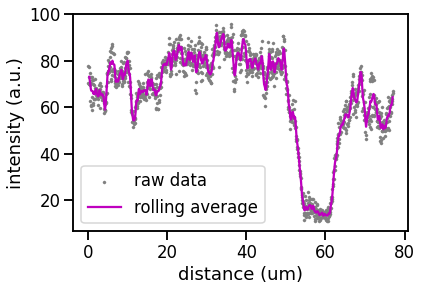

In [59]:
ax = sns.scatterplot(data=df_spat_wrk.loc[df_spat_wrk['time (s)']==0], 
             x='distance (um)', y='grey value', ci=None, 
             color='grey', s=10, edgecolor=None)
sns.lineplot(data=df_spat_wrk.loc[df_spat_wrk['time (s)']==0], 
             x='distance (um)', y='grey rolling', ci=None, 
             color='m')

ax.set_ylabel('intensity (a.u.)')

plt.legend(['raw data', 'rolling average'])

fig = ax.get_figure()

fig.savefig('initial-smoothing.png', dpi=300, bbox_inches='tight')

Step 2: show how that data evolves over time (using the smoothed data)

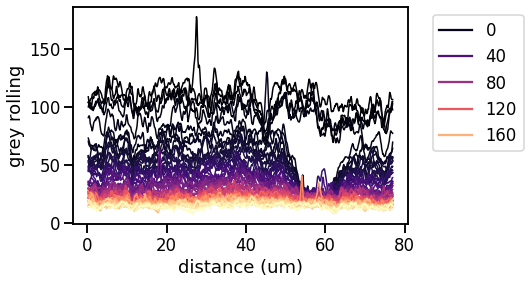

In [60]:
ax=sns.lineplot(data=df_spat_wrk, x='distance (um)', y='grey rolling', hue='time (s)', ci=None,
                palette='magma', linewidth=1.5)
ax.legend( bbox_to_anchor=(1.05, 1), loc=2 )

fig = ax.get_figure()

fig.savefig('timeprogression.png', dpi=300, bbox_inches='tight')

Step 3: Select the FRAP region and reference region specifically

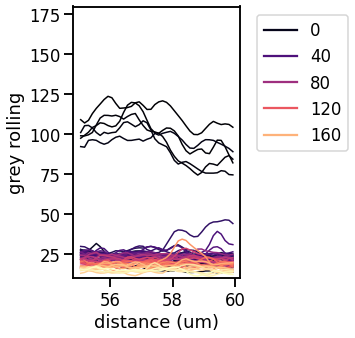

In [61]:
plt.figure(figsize=(3, 5))

df_FRAPregion = df_spat_wrk.loc[df_spat_wrk['distance (um)']<60]
df_FRAPregion = df_FRAPregion.loc[df_FRAPregion['distance (um)']>55]
ax=sns.lineplot(data=df_FRAPregion, x='distance (um)', y='grey rolling', hue='time (s)', ci=None,
                palette='magma', linewidth=1.5)
ax.legend( bbox_to_anchor=(1.05, 1), loc=2 )
ax.set_ylim(10,180)

fig = ax.get_figure()

fig.savefig('FRAPregion_55-60_tall.png', dpi=300, bbox_inches='tight')

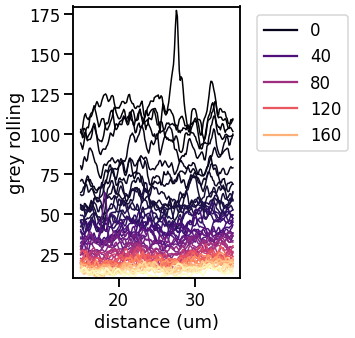

In [62]:
plt.figure(figsize=(3, 5))

df_REFregion = df_spat_wrk.loc[df_spat_wrk['distance (um)']<35]
df_REFregion = df_REFregion.loc[df_REFregion['distance (um)']>15]
ax=sns.lineplot(data=df_REFregion, x='distance (um)', y='grey rolling', hue='time (s)', ci=None,
                palette='magma', linewidth=1.5)
ax.legend( bbox_to_anchor=(1.05, 1), loc=2 )
ax.set_ylim(10,180)

fig = ax.get_figure()

fig.savefig('REFregion_15-35_tall.png', dpi=300, bbox_inches='tight')

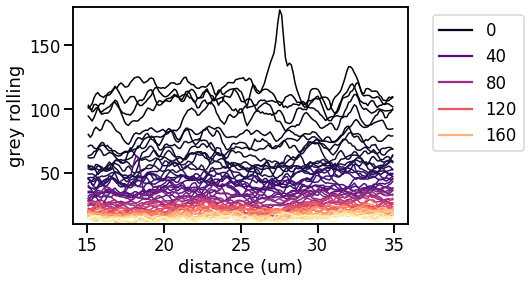

In [63]:
df_REFregion = df_spat_wrk.loc[df_spat_wrk['distance (um)']<35]
df_REFregion = df_REFregion.loc[df_REFregion['distance (um)']>15]
ax=sns.lineplot(data=df_REFregion, x='distance (um)', y='grey rolling', hue='time (s)', ci=None,
                palette='magma', linewidth=1.5)
ax.legend( bbox_to_anchor=(1.05, 1), loc=2 )
ax.set_ylim(10,180)

fig = ax.get_figure()

fig.savefig('REFregion_15-35.png', dpi=300, bbox_inches='tight')

Combine temporally and spatially resolved data in same df for ease of handling

In [64]:
df_temp_wrk['time (s)'] = df_temp_wrk['time (s)'].astype(float)
df_spat_wrk['time (s)'] = df_spat_wrk['time (s)'].astype(float)
df_wrk_all = df_spat_wrk.merge(df_temp_wrk, on='time (s)',suffixes=('', '_t'))

# bleach correct per line
df_wrk_all['intensity corrected framewise']=df_wrk_all['grey rolling']/df_wrk_all['intensity ref']

<ipython-input-64-599e872b59d3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_wrk['time (s)'] = df_temp_wrk['time (s)'].astype(float)
<ipython-input-64-599e872b59d3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_spat_wrk['time (s)'] = df_spat_wrk['time (s)'].astype(float)


Plot bleach corrected data over time

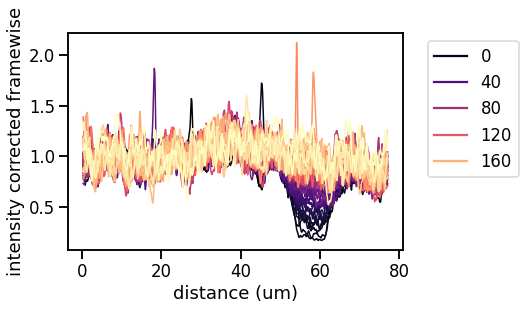

In [65]:
ax=sns.lineplot(data=df_wrk_all, x='distance (um)', y='intensity corrected framewise', hue='time (s)', ci=None,
                palette='magma', linewidth=1.5)
ax.legend( bbox_to_anchor=(1.05, 1), loc=2 )

fig = ax.get_figure()

fig.savefig('timeprogression_bleachcorrected.png', dpi=300, bbox_inches='tight')

Plot corrected data in FRAP region

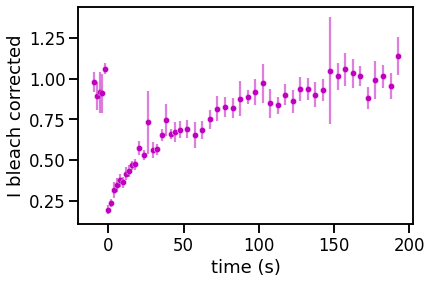

In [66]:
plt.figure(figsize=(6, 4))

ax=sns.scatterplot(
    data=df_wrk_all.groupby('time (s)').mean(), 
    x='time (s)', 
    y='FRAP intensity bleach corrected', color='m', s=40)
#errorbars
err_x = df_wrk_all['time (s)'].unique()
err_y = df_wrk_all.groupby('time (s)').mean()['FRAP intensity bleach corrected']
err_b = df_wrk_all.groupby('time (s)').mean()['sd intensity corrected']
plt.errorbar(err_x, err_y, err_b, color='m', ls='none', alpha=0.5)

ax.set_ylabel('I bleach corrected')

fig = ax.get_figure()

fig.savefig('FRAP-intensity_bleach-corrected.png', dpi=300, bbox_inches='tight')

### FRAP fitting and analysis

Define fit function

In [67]:
# define fit function
def FRAP_exp_single(t, A, omega):
    return   A * np.exp(-t*omega)

Fitting step 0: Normalize data so that pre-bleach corrected intensity has mean of 1 

In [68]:
df_FRAP_params = pd.DataFrame(columns=['experiment', 'Iinf', 'A', 'tau (s)', 'R2']) 

# normalize experimental data to starting intensity (I0=1)
I0 = df_wrk_all.loc[df_wrk_all['time (s)']<0].mean()['FRAP intensity bleach corrected']    
df_wrk_all['I norm'] = df_wrk_all['FRAP intensity bleach corrected'] / I0
df_wrk_all['sd I norm'] = df_wrk_all['sd intensity corrected'] / I0

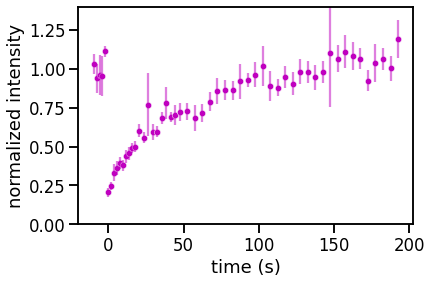

In [69]:
plt.figure(figsize=(6, 4))

ax=sns.scatterplot(
    data=df_wrk_all.groupby('time (s)').mean(), 
    x='time (s)', 
    y='I norm', color='m', s=40)
#errorbars
err_x = df_wrk_all['time (s)'].unique()
err_y = df_wrk_all.groupby('time (s)').mean()['I norm']
err_b = df_wrk_all.groupby('time (s)').mean()['sd I norm']
plt.errorbar(err_x, err_y, err_b, color='m', ls='none', alpha=0.5)

ax.set_ylabel('normalized intensity')
ax.set_ylim(0,1.4)

fig = ax.get_figure()

fig.savefig('FRAP-intensity_normalized.png', dpi=300, bbox_inches='tight')

Fitting step 1: determine asymptotic value by finding mean of last few values

In [70]:
# smooth intensity for more accurate final I
df_wrk_all['I rolling']=df_wrk_all['I norm'].rolling(window=3).mean()
tend = df_wrk_all['time (s)'].max()
Iinf = df_wrk_all.loc[df_wrk_all['time (s)']==tend, 'I rolling'].values[0]

Fitting step 2: Prepare data for fitting by inverting on asymptotic intensity

In [71]:
# invert data to fit with single exponential decay
df_wrk_all['Iinf-I'] = Iinf - df_wrk_all['I norm']

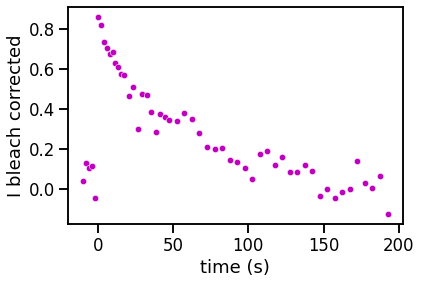

In [72]:
plt.figure(figsize=(6, 4))

ax=sns.scatterplot(
    data=df_wrk_all.groupby('time (s)').mean(), 
    x='time (s)', 
    y='Iinf-I', color='m', s=40)
#errorbars
#err_x = df_wrk_all['time (s)'].unique()
#err_y = df_wrk_all.groupby('time (s)').mean()['FRAP intensity bleach corrected']
#err_b = df_wrk_all.groupby('time (s)').mean()['sd intensity corrected']
#plt.errorbar(err_x, err_y, err_b, color='m', ls='none', alpha=0.5)

ax.set_ylabel('I bleach corrected')

fig = ax.get_figure()

fig.savefig('FRAP-intensity_inverted.png', dpi=300, bbox_inches='tight')

Fitting step 3: fit data (excluding 'before' times)

In [73]:
# define region in which recovery is actually taking place
df_working_recovery = df_wrk_all.loc[df_wrk_all['time (s)']>=0]

# fit single exponential decay
x = df_working_recovery['time (s)'].unique()
y = df_working_recovery.groupby('time (s)').mean()['Iinf-I'].values

guess = [1, 0.2]
c, cov = curve_fit( FRAP_exp_single, x, y, guess)
I_pred  =  FRAP_exp_single(x, c[0], c[1])
    
    
df_params_temp['Iinf'] = Iinf
df_params_temp['A'] = c[0]
df_params_temp['tau (s)'] = 1/c[1]
df_params_temp['R2'] = r2_score(y, I_pred)
df_params_temp['experiment'] = theexp

df_params_temp

,Iinf,A,tau (s),R2,experiment
0,1.067738,0.789131,55.257232,0.942204,20220204_run3_ves4


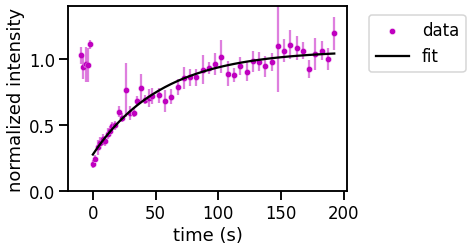

In [74]:
plt.figure(figsize=(5, 3.4))

ax=sns.scatterplot(
    data=df_wrk_all.groupby('time (s)').mean(), 
    x='time (s)', 
    y='I norm', color='m', s=40)
#errorbars
err_x = df_wrk_all['time (s)'].unique()
err_y = df_wrk_all.groupby('time (s)').mean()['I norm']
err_b = df_wrk_all.groupby('time (s)').mean()['sd I norm']
plt.errorbar(err_x, err_y, err_b, color='m', ls='none', alpha=0.5)

plt.plot(x, Iinf - I_pred, 'k')

plt.legend(['data', 'fit'],  bbox_to_anchor=(1.05, 1), loc=2 , )

ax.set_ylabel('normalized intensity')
ax.set_ylim(0,1.4)

fig = ax.get_figure()

fig.savefig('FRAP-fitted.png', dpi=300, bbox_inches='tight')

# Batch fitting of FRAP data

Load data (duplicate from cell at the very top; just to be sure that the dfs are clean)

In [79]:
df_temporal = pd.read_csv('20220208_FRAP-data_all_recovery.csv')
df_temporal.drop(columns=['Unnamed: 0'], inplace=True)

df_spatial = pd.read_csv('20220208_FRAP-data_all_spatiallyresolved.csv')
df_spatial.drop(columns=['Unnamed: 0'], inplace=True)

C:\Users\LBaldauf\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [80]:
df_FRAP_params = pd.DataFrame(columns=['experiment', 'Iinf', 'A', 'tau (s)', 'R2']) 

for theexp in df_temporal.loc[df_temporal['time (s)']==0]['experiment']:
    
    df_params_temp = pd.DataFrame()
    
    # select experimental data
    df_working = df_temporal.loc[df_temporal['experiment']==theexp]

    # normalize experimental data to starting intensity (I0=1)
    I0 = df_working.loc[df_working['time (s)']<0].mean()['FRAP intensity bleach corrected']    
    df_working['I norm'] = df_working['FRAP intensity bleach corrected'] / I0

    # smooth intensity for more accurate final I
    df_working['I rolling']=df_working['I norm'].rolling(window=3).mean()
    tend = df_working['time (s)'].max()
    Iinf = df_working.loc[df_working['time (s)']==tend, 'I rolling'].values

    # invert data to fit with single exponential decay
    df_working['Iinf-I'] = Iinf - df_working['I norm']


    # define region in which recovery is actually taking place
    df_working_recovery = df_working.loc[df_working['time (s)']>=0]

    # fit single exponential decay
    x = df_working_recovery['time (s)'].unique()
    y = df_working_recovery['Iinf-I'].values

    guess = [1, 0.2]
    c, cov = curve_fit( FRAP_exp_single, x, y, guess)
    I_pred  =  FRAP_exp_single(x, c[0], c[1])
    
    
    df_params_temp['Iinf'] = Iinf
    df_params_temp['A'] = c[0]
    df_params_temp['tau (s)'] = 1/c[1]
    df_params_temp['R2'] = r2_score(y, I_pred)
    df_params_temp['experiment'] = theexp
   
    
    
    
    df_FRAP_params = pd.concat([df_FRAP_params, df_params_temp])

<ipython-input-80-5fb9ab4783ac>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_working['I norm'] = df_working['FRAP intensity bleach corrected'] / I0
<ipython-input-80-5fb9ab4783ac>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_working['I rolling']=df_working['I norm'].rolling(window=3).mean()
<ipython-input-80-5fb9ab4783ac>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

<ipython-input-80-5fb9ab4783ac>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_working['I rolling']=df_working['I norm'].rolling(window=3).mean()
<ipython-input-80-5fb9ab4783ac>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_working['Iinf-I'] = Iinf - df_working['I norm']
<ipython-input-80-5fb9ab4783ac>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

In [81]:
df_FRAP_params

,experiment,Iinf,A,tau (s),R2
0,20220204_run4_old-ves1,0.632814,0.409994,11.143240,0.914169
0,20220204_run4_old-ves2,0.906845,0.554464,25.083111,0.942898
0,20220204_run4_old-ves3,1.041480,0.870189,61.166438,0.845805
0,20220204_run4_ves3,0.870677,0.688880,60.335269,0.981797
0,20220204_run4_ves4,1.134906,0.830582,114.802355,0.829628
0,20220204_run4_ves5,1.031975,0.657739,92.409215,0.668259
0,20220204_fascin_ves1,0.319633,0.267425,146.708215,0.667286
0,20220204_run3_ves1,0.946278,0.667101,58.856410,0.892790
0,20220204_run3_ves2,0.581012,0.330135,27.536329,0.450715
0,20220204_run3_ves3,1.252667,0.986630,84.018774,0.964563


Plot fit qualities vs recovery times

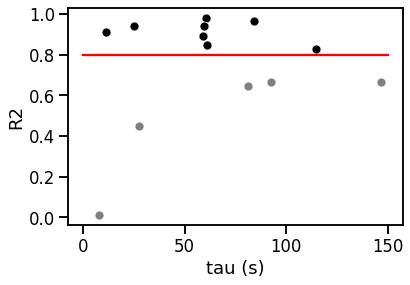

In [89]:
ax = sns.scatterplot(data=df_FRAP_params, x='tau (s)', y="R2", color='grey')
ax = sns.scatterplot(data=df_FRAP_params.loc[df_FRAP_params['R2']>=0.8], x='tau (s)', y="R2", color='k')

X=np.linspace(0,150)
Y = len(X)*[0.8]
plt.plot(X, Y, 'r')

fig = ax.get_figure()

fig.savefig('R2-vs-tau', dpi=300, bbox_inches='tight')

8


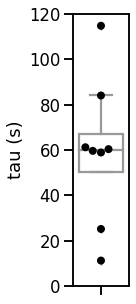

In [90]:
plt.figure(figsize=(1,5))

df=df_FRAP_params.loc[df_FRAP_params['experiment']!='20220204_fascin_ves1']

ax = sns.swarmplot(data=df.loc[df['R2']>0.8], y='tau (s)', color='k', s=8)
sns.boxplot(data=df.loc[df['R2']>0.8], y='tau (s)', color='w')

ax.set_ylim(0,120)


print(len(df.loc[df['R2']>0.8]))

fig = ax.get_figure()

fig.savefig('tau_swarmplot.png', dpi=300, bbox_inches='tight')

In [91]:
print( 'mean tau (s): ', df.loc[df['R2']>0.8].mean()['tau (s)'])
print( 'SD tau (s): ', df.loc[df['R2']>0.8].std()['tau (s)'])

mean tau (s):  59.37320806661106
SD tau (s):  32.04056791183231
